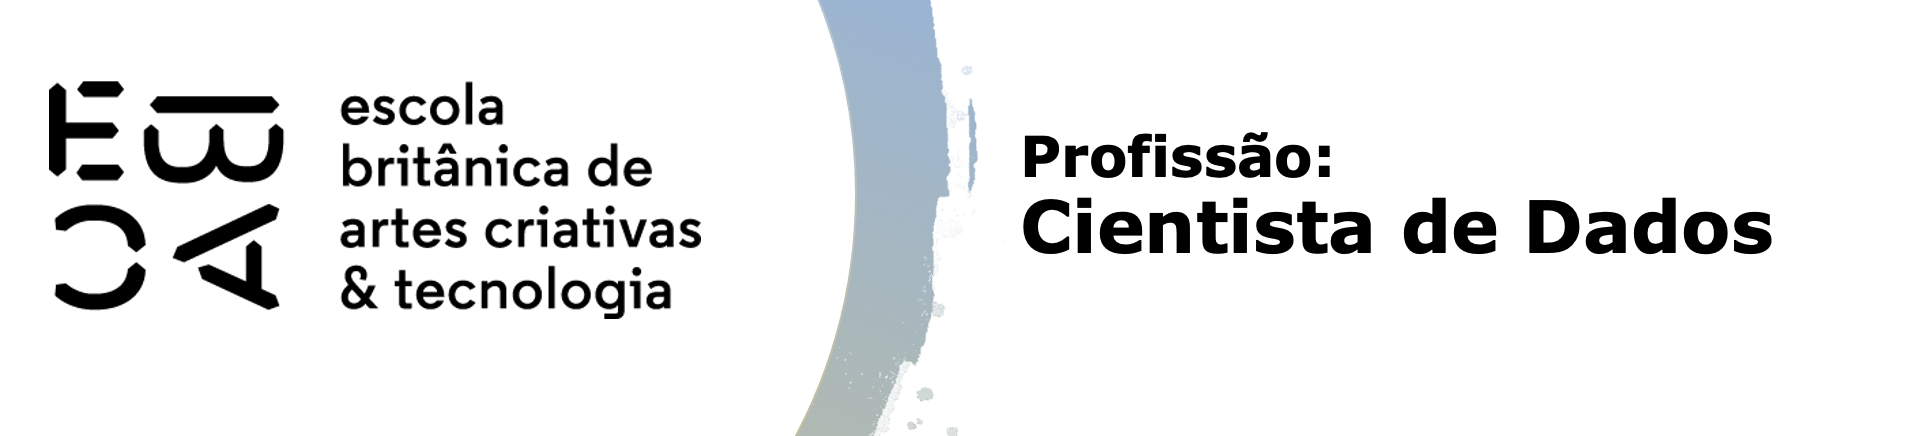

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix


### 2. Calcule os ```ccp_alphas```. 

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

C:\Users\djang\AppData\Local\Temp\ipykernel_9608\1575943886.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features_df = pd.read_csv(caminho_features, delim_whitespace=True, header=None, usecols=[1])
C:\Users\djang\AppData\Local\Temp\ipykernel_9608\1575943886.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y = pd.read_csv(caminho_y, delim_whitespace=True, header=None, names=['Activity'])
C:\Users\djang\AppData\Local\Temp\ipykernel_9608\1575943886.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X = pd.read_csv(caminho_X, delim_whitespace=True, header=None)
C:\Users\djang\AppData\Local\Temp\ipykernel_9608\1575943886.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv 

Melhor ccp_alpha: 0.003095042802249988, com acurácia média: 0.8115
Acurácia na base de teste: 0.7092


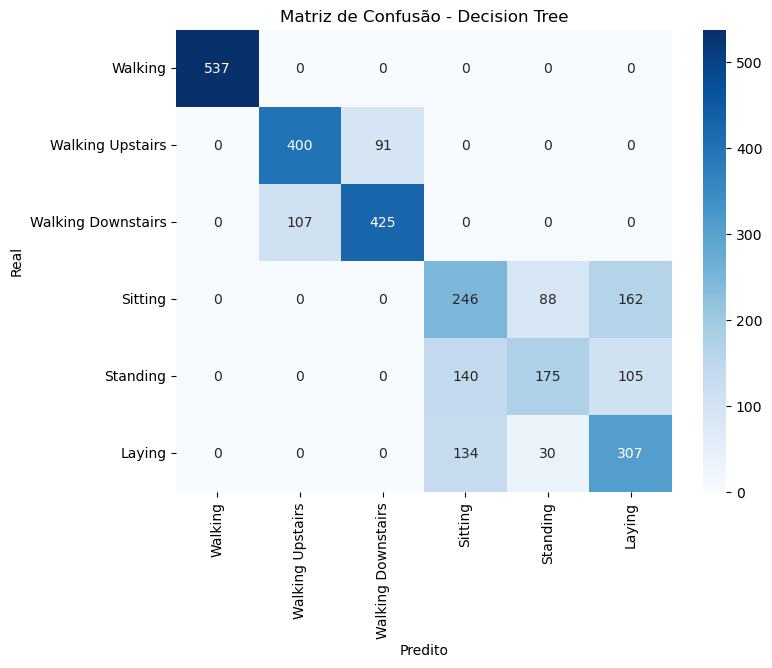

In [12]:
# Dicionário para mapear os IDs das atividades para os nomes corretos
activity_labels = {
    1: "Walking",
    2: "Walking Upstairs",
    3: "Walking Downstairs",
    4: "Sitting",
    5: "Standing",
    6: "Laying"
}

def process_data(caminho_features, caminho_subject, caminho_X, caminho_y, selected_columns=None, tipo='train'):
    os.makedirs("./output", exist_ok=True)

    # Carregar features.txt em uma Series (nomes das colunas)
    features_df = pd.read_csv(caminho_features, delim_whitespace=True, header=None, usecols=[1])
    features = features_df.squeeze().str.strip()
    features.name = 'Var'

    # Carregar os dados
    y = pd.read_csv(caminho_y, delim_whitespace=True, header=None, names=['Activity'])
    y['Activity'] = y['Activity'].map(activity_labels)

    X = pd.read_csv(caminho_X, delim_whitespace=True, header=None)
    X.columns = features  # Renomear colunas

    # Se for treino, definir as 3 melhores variáveis
    if tipo == 'train':
        clf = DecisionTreeClassifier(random_state=42)
        clf.fit(X, y['Activity'])
        importances = clf.feature_importances_
        
        top_features_idx = np.argsort(importances)[-3:]
        selected_columns = features.iloc[top_features_idx].values.tolist()
    
    # Garantir que o teste tenha as mesmas colunas que o treino
    X_selected = X[selected_columns] if selected_columns else X

    return X, X_selected, y, selected_columns

# Função para encontrar o melhor ccp_alpha usando validação cruzada K-Fold
def find_best_ccp_alpha(X_train, y_train, cv=10):
    clf = DecisionTreeClassifier(random_state=42)
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas = np.unique(path.ccp_alphas[path.ccp_alphas > 0])  # Filtrar valores positivos
    ccp_alphas = ccp_alphas[::10]  # Selecionar 1 a cada 10 valores para otimizar o tempo

    best_alpha = None
    best_accuracy = 0

    for alpha in ccp_alphas:
        model = DecisionTreeClassifier(ccp_alpha=alpha, random_state=42)
        scores = cross_val_score(model, X_train, y_train, cv=cv)
        mean_accuracy = scores.mean()

        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_alpha = alpha

    print(f"Melhor ccp_alpha: {best_alpha}, com acurácia média: {best_accuracy:.4f}")
    return best_alpha

# Processar os dados de treino
X_train, X_train_selected, y_train, selected_features = process_data(
    "UCI HAR Dataset/features.txt",
    "UCI HAR Dataset/train/subject_train.txt",
    "UCI HAR Dataset/train/X_train.txt",
    "UCI HAR Dataset/train/y_train.txt",
    tipo="train"
)

# Processar os dados de teste com as mesmas colunas do treino
X_test, X_test_selected, y_test, _ = process_data(
    "UCI HAR Dataset/features.txt",
    "UCI HAR Dataset/test/subject_test.txt",
    "UCI HAR Dataset/test/X_test.txt",
    "UCI HAR Dataset/test/y_test.txt",
    selected_columns=selected_features,  # Garante que o teste use as mesmas colunas
    tipo="test"
)

# Reordenar colunas do X_test_selected para garantir que coincidem com X_train_selected
X_test_selected = X_test_selected[selected_features]

# Encontrar o melhor ccp_alpha
best_ccp_alpha = find_best_ccp_alpha(X_train_selected, y_train['Activity'], cv=10)

# Treinar a árvore final com o melhor ccp_alpha
final_model = DecisionTreeClassifier(ccp_alpha=best_ccp_alpha, random_state=42)
final_model.fit(X_train_selected, y_train['Activity'])

# Avaliação na base de teste
y_pred = final_model.predict(X_test_selected)
test_accuracy = accuracy_score(y_test['Activity'], y_pred)
conf_matrix = confusion_matrix(y_test['Activity'], y_pred)

print(f"Acurácia na base de teste: {test_accuracy:.4f}")

# Criar um heatmap da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=activity_labels.values(), yticklabels=activity_labels.values())
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Decision Tree")
plt.show()

### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

Novas variáveis selecionadas: ['fBodyGyro-std()-X', 'angle(Y,gravityMean)', 'tGravityAcc-min()-X']
Acurácia após incluir novas variáveis: 0.7167


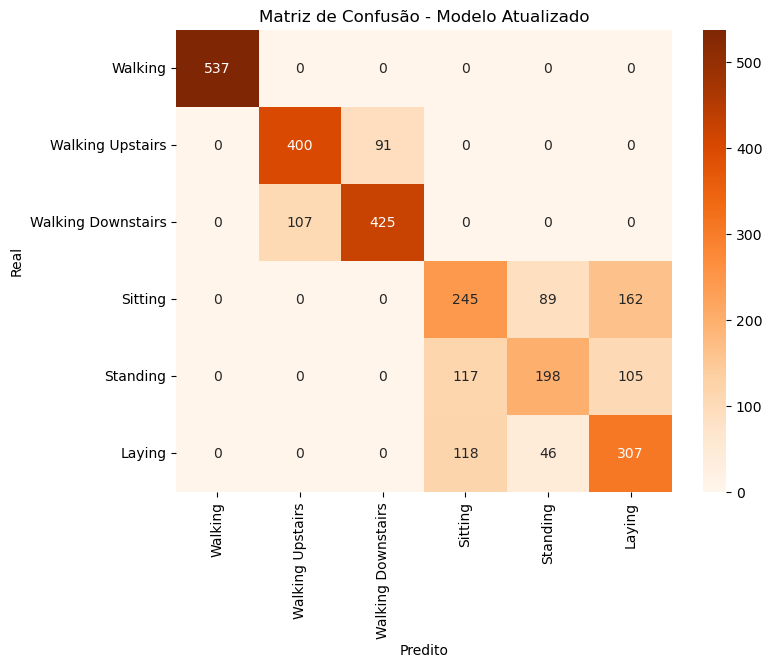

In [18]:
# Criando variável binária para a classe mais difícil de classificar
y_train_binary = (y_train["Activity"] == "Sitting").astype(int)
y_test_binary = (y_test["Activity"] == "Sitting").astype(int)

# Treinando uma nova árvore simples para detectar essa classe
binary_tree = DecisionTreeClassifier(min_samples_leaf=20, max_depth=4, random_state=42)
binary_tree.fit(X_train, y_train_binary)

# Identificar as 3 variáveis mais importantes
binary_importances = binary_tree.feature_importances_
top_binary_features_idx = np.argsort(binary_importances)[-3:]
selected_columns_new = X_train.columns[top_binary_features_idx].tolist()

print(f"Novas variáveis selecionadas: {selected_columns_new}")

# Evitar duplicação de colunas ao adicionar novas variáveis
new_columns = [col for col in selected_columns_new if col not in X_train_selected.columns]

# Criando novos conjuntos de dados
if new_columns:
    X_train_updated = X_train_selected.join(X_train[new_columns])
    X_test_updated = X_test_selected.join(X_test[new_columns])
else:
    X_train_updated = X_train_selected
    X_test_updated = X_test_selected

# Treinar novo modelo com variáveis adicionais
final_model_updated = DecisionTreeClassifier(ccp_alpha=best_ccp_alpha, random_state=42)
final_model_updated.fit(X_train_updated, y_train["Activity"])

y_pred_updated = final_model_updated.predict(X_test_updated)

# Avaliação do novo modelo
test_accuracy_updated = accuracy_score(y_test["Activity"], y_pred_updated)
conf_matrix_updated = confusion_matrix(y_test["Activity"], y_pred_updated)

print(f"Acurácia após incluir novas variáveis: {test_accuracy_updated:.4f}")

# Plotando nova Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_updated, annot=True, fmt="d", cmap="Oranges",
            xticklabels=activity_labels.values(), yticklabels=activity_labels.values())
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Modelo Atualizado")
plt.show()